______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*:
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022

Datos provistos por [properati](https://www.properati.com.ar).
______________________________________


In [1]:
# pip install visualkeras

In [1]:
#Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import visualkeras as vk
from keras.metrics import RootMeanSquaredError
from keras.metrics import MeanSquaredError

#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

if IN_COLAB :
    from google.colab import drive
    drive.mount('/content/drive')
    properati = pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/1d_df_reducido.csv')
    properati_decrip = pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021_decrip.csv')
else:
    properati=pd.read_csv('./1d_df_reducido.csv')
    properati_decrip = pd.read_csv('properati_argentina_2021_decrip.csv')

from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
def metricas(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

2022-12-06 20:20:39.625197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 20:20:39.734781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 20:20:39.734794: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 20:20:40.274353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## 1.Procesamiento del Lenguaje Natural
### 1.a Ampliación del dataset

In [6]:
df_decrip = pd.merge(properati, properati_decrip, on="id")
df_decrip = df_decrip[["id", "property_description"]]
df_decrip

,id,property_description
0,1gMQ4rXcpnPs+hhvW11Jdw==,"ESPECTACULAR 4 AMBIENTES, DORMITORIO SUITE, BA..."
1,p7gmyqzdOy/+odHwH5oPyg==,"Excelente departamento, piso alto con una herm..."
2,ZYkS+4dCz1vUENzAREcX9w==,Corredor Responsable: Gustavo Guastello - C.U....
3,UL/s8zoicLDXXwhaelBgFQ==,Corredor Responsable: GRACIELA MENAZZI CMCPDJL...
4,wnz+hkCE7RVBNcqDQEtFSw==,Muy lindo y funcional departamento de un ambie...
...,...,...
74248,CIrzzz0KQkUDDmjnFINLwA==,MONOAMBIENTE DIVIDIDO. FRENTE. 29 M2. IMPECABL...
74249,i5lDg1C7ZEZyETXxCbolhw==,Departamento. Edificio OM Palermo. Living/Come...
74250,b97ekVIR18ZDn3ZsDXWrVQ==,Tres ambientes en Balvanera reciclado a nuevo!...
74251,7oLMN+ZSoOP2N9Uu7Pz68A==,Corredor Responsable: Micaela Perez / Lucas Fe...


In [7]:
df_decrip['property_description'].isna().sum()

0

In [ ]:
from collections import Counter
Counter(" ".join(df_decrip["property_description"]).split()).most_common(100)


In [ ]:
df_decrip["property_description"]

In [ ]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: line.replace("<br>", " ")) # remover etiqueta de html
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: line.lower()) # Todo a minúsculas
import unidecode
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: unidecode.unidecode(line)) # Sin tildes por posibles errores de gramática

In [ ]:
import re
# df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: re.sub("[^\\w-]+", " ", line)) #Remueve simbolos menos el -
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line)) # remover símbolos

In [ ]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line)) # remover multiples espacios para facilitar lectura

In [ ]:
# export = df_decrip["property_description"].head()
# np.savetxt('export.txt', export.values, fmt='%s')

In [ ]:
df_nostopwords = df_decrip.copy()

with open('stopwords') as f:
    lines = f.read().splitlines()

f = lambda x: ' '.join([item for item in x.split() if item not in lines]) #remueve stopwords
df_nostopwords["property_description"] = df_nostopwords["property_description"].apply(f)

df_nostopwords["property_description"].head(10)


In [ ]:
from collections import Counter
Counter(" ".join(df_nostopwords["property_description"]).split()).most_common(100)

Seleccionamos los aspectos que nos parecen relevantes, para luego buscar sus posibles valores.
Los aspectos elegidos son: Cocina, pisos, calefaccion, expensas, lavadero, balcon,  cochera y aire.

In [ ]:
from types import NoneType
aspectos = ['cocina', 'pisos', 'calefaccion', 'expensas', 'lavadero', 'balcon', 'cochera', 'aire']

def f(line, word):
    format = r"\W*([\w]+)"
    n = 2
    x = re.search(r'{}\W*{}{}'.format(format*n, word, format*n), line)
    if not isinstance(x, NoneType):
        return x.group()
    else:
        return ""

for word in aspectos:
    df_nostopwords[word] = df_nostopwords["property_description"].apply(lambda line: f(line, word))

In [ ]:
cant_val_aspectos = 15

In [ ]:
Counter(" ".join(df_nostopwords["cocina"]).split()).most_common(cant_val_aspectos)

Para Cocina, posibles valores son: integrada, separada, independiente, completa

In [ ]:
Counter(" ".join(df_nostopwords["pisos"]).split()).most_common(cant_val_aspectos)

Para pisos, posibles valores son: porcelanato, parquet, madera, ceramicos

In [ ]:
Counter(" ".join(df_nostopwords["calefaccion"]).split()).most_common(cant_val_aspectos)

Para calefaccion, posibles valores son: radiadores, radiante, central, individual

In [ ]:
Counter(" ".join(df_nostopwords["expensas"]).split()).most_common(cant_val_aspectos)

Para expensas, posibles valores son: bajas, incluye

In [ ]:
Counter(" ".join(df_nostopwords["lavadero"]).split()).most_common(cant_val_aspectos)

Para lavadero, posibles valores son: independiente, separado

In [ ]:
Counter(" ".join(df_nostopwords["balcon"]).split()).most_common(cant_val_aspectos)

Para balcon, posibles valores son: frente, amplio, terraza, salida, corrido

In [ ]:
Counter(" ".join(df_nostopwords["cochera"]).split()).most_common(cant_val_aspectos*2)

Para cochera, posibles valores son: cubierta, descubierta, opcional

In [ ]:
Counter(" ".join(df_nostopwords["aire"]).split()).most_common(cant_val_aspectos)

Para aire, posibles valores son: split, central, acondicionado

Teniendo en cuenta los posibles valores para los aspectos considerados, decidimos descartar lavadero.
De esta forma, nuestros aspectos serán: Cocina, pisos, calefaccion, expensas, balcon,  cochera y aire.

In [ ]:
aspectos = ['cocina', 'pisos', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire']

A continuación creamos la variable values, que contiene los posibles valores para cada uno de los aspectos elegidos.

In [ ]:
values_cocina = ['integrada', 'separada', 'independiente', 'completa']
values_pisos = ['porcelanato', 'madera', 'parquet', 'ceramicos']
values_calefaccion = ['radiadores', 'radiante', 'central', 'individual']
values_expensas = ['bajas', 'incluye']
values_balcon = ['frente', 'amplio', 'terraza', 'salida', 'corrido']
values_cochera = ['opcional', 'cubierta', 'descubierta']
values_aire = ['split', 'central', 'acondicionado']

values = [values_cocina, values_pisos, values_calefaccion, values_expensas, values_balcon, values_cochera, values_aire]

En primer lugar creo un dataframe auxiliar que tenga los IDs y las columnas de aspectos

In [ ]:
aux_df = df_nostopwords.copy()
aux_df.drop('property_description', inplace=True, axis=1)

Luego creamos una función a la que; pasandole un dataframe, los aspectos y el listado de valores posibles, reemplace el contenido de las columnas por los valores correspondientes

In [ ]:
def limpiar_values_de_aspects(df, aspects, values):
    i = 0
    for aspect in aspects:
        for word in values[i]:
            df[aspect] = df[aspect].apply(lambda line: word if word in line else line)
        df[aspect] = df[aspect].apply(lambda line: line if len(line.split())<2 else '')
        i = i+1

Ahora modificamos las columnas de los aspectos, para que solo queden los valores.

In [ ]:
limpiar_values_de_aspects(aux_df, aspectos, values)
aux_df.drop("lavadero", axis=1, inplace=True)
aux_df.head(20)

Por último hacemos el merge con el dataframe original, teniendo en cuenta los ID

In [ ]:
df = properati.copy()
df = pd.merge(df,aux_df, on="id")
df

### 1.b Modelos

Primero entrenamos un modelo sin las nuevas columnas como en el TP1

In [ ]:
df_TP1= pd.get_dummies(properati, columns=['place_l4', 'property_type'], drop_first=True)
train = df_TP1.sample(frac=0.8, random_state=200)
y_train = train["property_price"]
train.drop(["property_price", "id"], inplace=True, axis=1)
test = df_TP1.drop(train.index)
y_test = test["property_price"]
test.drop(["property_price", "id"], inplace=True, axis=1)

In [ ]:
param_grid = {'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.5}
xgb_regressor = XGBRegressor(**param_grid).fit(train, y_train)
predictions = xgb_regressor.predict(test)
xgb_regressor.score(test, y_test)

Ahora entrenamos un modelo con las nuevas columnas.

Realizamos one hot encoding para las variables cualitativas:

In [ ]:
df_dummies = pd.get_dummies(df, columns=['place_l4', 'property_type', 'cocina', 'pisos', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)
df_dummies

Separamos el dataset en train y test

In [ ]:

train = df_dummies.sample(frac=0.8, random_state=200)
y_train = train["property_price"]
train.drop(["property_price", "id"], inplace=True, axis=1)
test = df_dummies.drop(train.index)
y_test = test["property_price"]
test.drop(["property_price", "id"], inplace=True, axis=1)
# train
y_train

In [ ]:
from xgboost import XGBRegressor
param_grid = {'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.5}
xgb_regressor = XGBRegressor(**param_grid).fit(train, y_train)

In [ ]:
predictions = xgb_regressor.predict(test)
predictions

In [ ]:
xgb_regressor.score(test,y_test)

Vemos que mejora un poco el score con las nuevas columnas.

Ahora optimizamos los hiperparámetros con el nuevo dataset ampliado:

In [ ]:
import sklearn as sk
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

params_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.30],
               'max_depth': [3, 4, 5, 6, 8],
               'min_child_weight': [1, 3, 5, 7],
               'gamma': [0.1, 0.2 , 0.3, 0.4],
               'colsample_bytree' : [0.3, 0.4, 0.5 , 0.7]}

randomCV = RandomizedSearchCV(estimator = XGBRegressor(),
                              param_distributions = params_grid,
                              scoring = make_scorer(accuracy_score),
                              cv = StratifiedKFold(n_splits = 5),
                              n_iter = 5)

randomCV.fit(train, y_train)

In [ ]:
y_pred = randomCV.predict(test)
metricas(y_test, y_pred)

In [ ]:
randomCV.best_params_

Observamos que el score no sufrió cambios drásticos

## 2.Redes Neuronales
### 2.a Regresión

Tomamos el dataset reducido del TP1 como punto de partida, luego aplicamos One Hot Encoding y separamos en train y test.
Adicionalmente dropeamos la columna 'property_price' en ambos datasets.

In [10]:
df_trabajo = properati.copy()
df_trabajo = pd.get_dummies(df_trabajo, columns=['place_l4', 'property_type'], drop_first=False)

train = df_trabajo.sample(frac=0.8, random_state=200)
y_train = train["property_price"]
train.drop(["property_price", "id"], inplace=True, axis=1)

test = df_trabajo.drop(train.index)
y_test = test["property_price"]
test.drop(["property_price", "id"], inplace=True, axis=1)

Normalizamos las entradas con StandardScaler

In [11]:
sscaler = StandardScaler()

train['start_date'] = sscaler.fit_transform(pd.DataFrame(train['start_date']))
test['start_date'] = sscaler.transform(pd.DataFrame(test['start_date']))

train['end_date'] = sscaler.fit_transform(pd.DataFrame(train['end_date']))
test['end_date'] = sscaler.transform(pd.DataFrame(test['end_date']))

train['latitud'] = sscaler.fit_transform(pd.DataFrame(train['latitud']))
test['latitud'] = sscaler.transform(pd.DataFrame(test['latitud']))

train['longitud'] = sscaler.fit_transform(pd.DataFrame(train['longitud']))
test['longitud'] = sscaler.transform(pd.DataFrame(test['longitud']))

train['property_rooms'] = sscaler.fit_transform(pd.DataFrame(train['property_rooms']))
test['property_rooms'] = sscaler.transform(pd.DataFrame(test['property_rooms']))

train['property_surface_total'] = sscaler.fit_transform(pd.DataFrame(train['property_surface_total']))
test['property_surface_total'] = sscaler.transform(pd.DataFrame(test['property_surface_total']))

train

,start_date,end_date,latitud,longitud,property_rooms,property_surface_total,place_l4_Abasto,place_l4_Agronomía,place_l4_Almagro,place_l4_Balvanera,...,place_l4_Villa Pueyrredón,place_l4_Villa Real,place_l4_Villa Riachuelo,place_l4_Villa Santa Rita,place_l4_Villa Soldati,place_l4_Villa Urquiza,place_l4_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
25158,-0.613612,-0.186383,-1.386003,0.169489,-0.610560,-0.641609,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23761,-0.323517,-0.800681,-0.260318,0.997661,0.987170,-0.074216,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
442,0.759506,-0.107119,0.112234,-2.097538,0.987170,-0.058881,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
67780,-0.777999,-0.800681,0.187259,1.077535,-0.610560,-0.411585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
58586,-1.000406,-1.203608,-0.553215,-2.398597,0.987170,0.094469,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45547,0.150306,-0.391149,0.709401,-1.721388,0.188305,0.324493,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2931,-0.748990,-0.714812,-0.300448,-0.115440,0.987170,-0.028211,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
49368,0.875544,0.216543,-1.175561,-0.481700,-1.409425,-0.810294,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37511,0.517760,0.758182,1.101048,-0.505068,0.987170,0.646527,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Creamos el modelo con 2 capas ocultas, entrada de igual cantidad de columnas que el dataset, y salida de 1 parámetro.
Luego lo compilamos utilizando RMSprop como optimizador, lo entrenamos con el dataset de train, y predecimos con el de test.

In [12]:
d_in=train.shape[1]

modelo = keras.Sequential([
    keras.layers.Dense(d_in, input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 71)                5112      
                                                                 
 dense_4 (Dense)             (None, 30)                2160      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 7,303
Trainable params: 7,303
Non-trainable params: 0
_________________________________________________________________


In [13]:
modelo.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

cant_epochs = 100
historia = modelo.fit(train, y_train, epochs=cant_epochs, verbose=False, use_multiprocessing=True, workers=4)
y_pred = modelo.predict(test)

465/465 [==============================] - 0s 564us/step


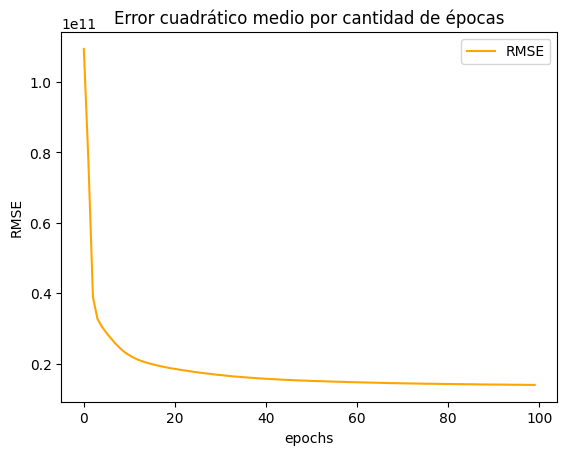

In [16]:
epochs = range(cant_epochs)
plt.plot(epochs, historia.history['loss'], color='orange', label='RMSE')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.title('Error cuadrático medio por cantidad de épocas')
plt.legend()

In [58]:
res = modelo.evaluate(test, y_test)
error = np.absolute(np.diagonal(np.subtract(y_test.values, y_pred)))
error_porcentual = error / y_test.values
print('El error relativo porcentual promedio es:', round(np.mean(error_porcentual),2), 'y su mediana es:', round(np.median(error_porcentual),2))
print('El error RMS es:', round(res[1],2))

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1758, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


### 2.b Clasificación

Generamos la variable target tipo_precio como en el TP1, aplicamos one hot encoding, dividimos en train - test y normalizamos mediante z-score:

In [47]:
df_trabajo = properati.copy()
df_trabajo["property_m2price"] = df_trabajo["property_price"] / df_trabajo["property_surface_total"]
df_trabajo.sort_values(by=["property_m2price"], inplace=True)

df_trabajo['tipo_precio_3'] = pd.qcut(x=df_trabajo.loc[df_trabajo['property_type'] == 'Departamento']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio")
df_trabajo['tipo_precio_3'].fillna(pd.qcut(x=df_trabajo.loc[df_trabajo['property_type'] == 'Casa']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio"), inplace=True)
df_trabajo['tipo_precio_3'].fillna(pd.qcut(x=df_trabajo.loc[df_trabajo['property_type'] == 'PH']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio"), inplace=True)

In [48]:
df_trabajo = pd.get_dummies(df_trabajo, columns=['place_l4', 'property_type'], drop_first=False)


train = df_trabajo.sample(frac=0.8, random_state=200)
y_train = train["tipo_precio_3"]
train.drop(["property_price", "id", "tipo_precio_3", "property_m2price"], inplace=True, axis=1)

train[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(train[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

test = df_trabajo.drop(train.index)
y_test = test["tipo_precio_3"]
test.drop(["property_price", "id", "tipo_precio_3", "property_m2price"], inplace=True, axis=1)

test[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(test[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

Modelamos con 1 capa oculta de 50 unidades, que recibe como entrada las columnas del dataset. La salida tiene 3 unidades.

In [50]:
d_in=train.shape[1]
modelo = keras.Sequential([
    keras.layers.Dense(50, input_shape=(d_in,)),
    keras.layers.Dense(3, activation='softmax')
])

modelo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                3600      
                                                                 
 dense_13 (Dense)            (None, 3)                 153       
                                                                 
Total params: 3,753
Trainable params: 3,753
Non-trainable params: 0
_________________________________________________________________


Aplicamos one hot encoding a y_train, para que tenga 3 columnas al igual que la salida del modelo.

In [51]:
y_train = pd.get_dummies(y_train, columns=['tipo_precio_3'], drop_first=False)
y_train

,bajo,medio,alto
52856,0,1,0
46654,0,1,0
37932,1,0,0
9614,0,0,1
630,0,0,1
...,...,...,...
36468,0,1,0
46494,1,0,0
9659,0,1,0
56568,0,1,0


Compilamos el modelo con optimizador Adam y loss de crossentropy categórico. Luego entrenamos con los datos de train y predecimos con test.

In [52]:
modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['AUC', 'Accuracy', 'Recall', 'Precision'],
)

cant_epochs=100
historia = modelo.fit(train, y_train, epochs=cant_epochs, verbose=False, use_multiprocessing=True, workers=4)

In [53]:
y_pred = modelo.predict(test)

465/465 [==============================] - 0s 516us/step


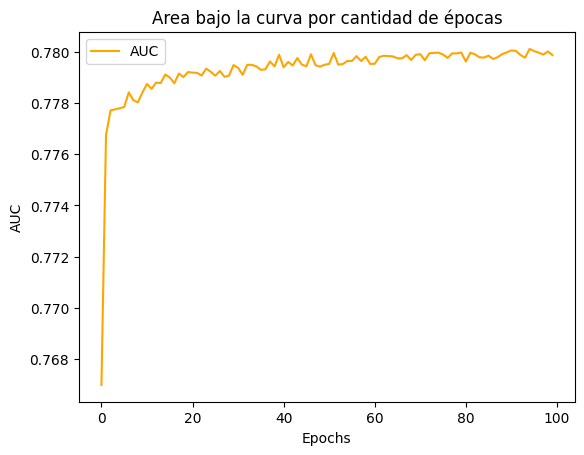

In [59]:
epochs = range(cant_epochs)

plt.plot(epochs, historia.history['auc'], color='orange', label='AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title('Area bajo la curva por cantidad de épocas')
plt.legend()

Reorganizamos los valores predichos para que queden en una sola columna, y comparamos con y_test

In [57]:
def myfunction(x):
    mx = max(x[0], x[1], x[2])
    if mx == x[0]:
        return "bajo"
    elif mx == x[1]:
        return "medio"
    elif mx == x[2]:
        return "alto"

y_pred_txt = np.apply_along_axis(myfunction, axis=1, arr=y_pred)
metricas(y_test, y_pred_txt)

Accuracy: 0.57
Precision: 0.63
Recall: 0.49
F1 Score: 0.48


array(['medio', 'medio', 'alto', ..., 'medio', 'medio', 'medio'],
      dtype='<U5')